# Sentiment Analysis

*_Adapted from https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb_

## Preparing Data

As before, we'll set the seed, define the `Fields` and get the train/valid/test splits.

We'll be using *packed padded sequences*, which will make our RNN only process the non-padded elements of our sequence, and for any padded element the `output` will be a zero tensor. To use packed padded sequences, we have to tell the RNN how long the actual sequences are. We do this by setting `include_lengths = True` for our `TEXT` field. This will cause `batch.text` to now be a tuple with the first element being our sentence (a numericalized tensor that has been padded) and the second element being the actual lengths of our sentences.

In [1]:
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import pickle5 as pickle
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets

from textutils import *


##
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)

LABEL = data.LabelField(dtype = torch.float)
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)


# local sizes
L = 8
datanumber=(np.random.RandomState(42).randint(100,1000,L) / 5).astype(int) #np.array([1000]*10)
k_weights = datanumber/datanumber.sum()
datanumber=(k_weights*len(train_data)).astype(int)
print(datanumber)

# selected users from FL_MAIN
with open('usersel.dict.pkl', 'rb') as handle:
    user_sel_dict = pickle.load(handle)
    
user_sel_dict['Rand'].shape

# split
train_data, valid_data = train_data.split(random_state = random.seed(SEED))
print(len(train_data), len(valid_data), len(test_data))

train_data_loc = [None for _ in k_weights]
train_data_loc[0] = train_data
for i, w in enumerate(k_weights):
    if i < len(k_weights)-1:
        train_data_loc[i], train_data_loc[i+1] = train_data_loc[i].split(
            w/sum(k_weights[i:]), random_state = random.seed(SEED)
        )
    print(len(train_data_loc[i]), end='-')

[1488 3980 7142 2752 1525 1264 5952  892]
17500 7500 25000
1042-2786-5000-1927-1068-885-4167-625-

In [2]:
1042+2786+5000+1927+1068+885+4167+625

17500

Next is the use of pre-trained word embeddings. Now, instead of having our word embeddings initialized randomly, they are initialized with these pre-trained vectors.
We get these vectors simply by specifying which vectors we want and passing it as an argument to `build_vocab`. `TorchText` handles downloading the vectors and associating them with the correct words in our vocabulary.

Here, we'll be using the `"glove.6B.100d" vectors"`. `glove` is the algorithm used to calculate the vectors, go [here](https://nlp.stanford.edu/projects/glove/) for more. `6B` indicates these vectors were trained on 6 billion tokens and `100d` indicates these vectors are 100-dimensional.

You can see the other available vectors [here](https://github.com/pytorch/text/blob/master/torchtext/vocab.py#L113).

The theory is that these pre-trained vectors already have words with similar semantic meaning close together in vector space, e.g. "terrible", "awful", "dreadful" are nearby. This gives our embedding layer a good initialization as it does not have to learn these relations from scratch.

**Note**: these vectors are about 862MB, so watch out if you have a limited internet connection.

By default, TorchText will initialize words in your vocabulary but not in your pre-trained embeddings to zero. We don't want this, and instead initialize them randomly by setting `unk_init` to `torch.Tensor.normal_`. This will now initialize those words via a Gaussian distribution.

In [3]:
MAX_VOCAB_SIZE = 5000
EMBEDDING_DIM = 50

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = f"glove.6B.{EMBEDDING_DIM}d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

As before, we create the iterators, placing the tensors on the GPU if one is available.

Another thing for packed padded sequences all of the tensors within a batch need to be sorted by their lengths. This is handled in the iterator by setting `sort_within_batch = True`.

In [4]:
BATCH_SIZE = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

iterators_list = data.BucketIterator.splits(
    (*train_data_loc, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    shuffle = True,
    device = device)

train_iterator_loc = iterators_list[:-2]
valid_iterator = iterators_list[-2]
test_iterator = iterators_list[-1]

## Build the Model

The model features the most drastic changes.

......

In [6]:
import copy 

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]


hyper_params = [
    INPUT_DIM, 
    EMBEDDING_DIM, 
    HIDDEN_DIM, 
    OUTPUT_DIM, 
    N_LAYERS, 
    BIDIRECTIONAL, 
    DROPOUT, 
    PAD_IDX
]


model = RNN(*hyper_params)
models_loc = [RNN(*hyper_params) for _ in range(L)]

print(f'The model has {count_parameters(model):,} trainable parameters')

# proc embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
print(pretrained_embeddings.shape)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
print(model.embedding.weight.data)

# local models init
_ = [m.load_state_dict(model.state_dict()) for m in models_loc]

The model has 829,941 trainable parameters
torch.Size([5002, 50])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        ...,
        [ 0.0259,  0.0087, -0.4666,  ..., -0.3948,  0.1668,  0.3416],
        [ 0.6582,  0.0605,  1.0938,  ...,  0.4864, -0.1341, -0.1038],
        [-1.3016,  0.5405, -0.3055,  ..., -0.8587, -0.4758,  0.0349]])


We can now see the first two rows of the embedding weights matrix have been set to zeros. As we passed the index of the pad token to the `padding_idx` of the embedding layer it will remain zeros throughout training, however the `<unk>` token embedding will be learned.

## Train the Model

Now to training the model.

The only change we'll make here is changing the optimizer from `SGD` to `Adam`. SGD updates all parameters with the same learning rate and choosing this learning rate can be tricky. `Adam` adapts the learning rate for each parameter, giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates. More information about `Adam` (and other optimizers) can be found [here](http://ruder.io/optimizing-gradient-descent/index.html).

To change `SGD` to `Adam`, we simply change `optim.SGD` to `optim.Adam`, also note how we do not have to provide an initial learning rate for Adam as PyTorch specifies a sensibile default initial learning rate.

In [9]:
from textutils import *
import torch.optim as optim
import time 


Finally, we train our model...

In [11]:
N_EPOCHS = 100

best_valid_loss = float('inf')

for run in range(1,10):
    for alloc in ['Rand', 'Orth', 'PDG', 'PDM', 'Ideal FL']:

        #########################################################    
        model = RNN(*hyper_params)
        models_loc = [RNN(*hyper_params) for _ in range(L)]
        # proc embedding
        pretrained_embeddings = TEXT.vocab.vectors
        model.embedding.weight.data.copy_(pretrained_embeddings)

        UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
        model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
        model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

        # local models init
        [m.load_state_dict(model.state_dict()) for m in models_loc]

        # adam opt
        optimizers_loc = [
            optim.Adam(
                models_loc[mi].parameters(), 
                lr=2e-3, eps=1e-5,
                weight_decay=1e-4
            ) 
            for mi in range(L)
        ]

        # loss
        criterion = nn.BCEWithLogitsLoss()

        # to gpu
        model = model.to(device)
        [m.to(device) for m in models_loc]
        criterion = criterion.to(device)
        #########################################################

        ##
        if 1:#alloc not in val_loss_all:
            train_loss_all[alloc] = []
            train_acc_all[alloc] = []
            val_loss_all[alloc] = []
            val_acc_all[alloc] = []

        for epoch in range(N_EPOCHS):
            print(epoch)
            if epoch in []:
                for mi in range(len(optimizers_loc)):
                    for g in optimizers_loc[mi].param_groups:
                        g['lr'] *= 0.5
                print('reducing learning rate to', g['lr'])

            start_time = time.time()

            # local learning
            #users_sel = np.random.rand(8)<.7
            users_sel = user_sel_dict[alloc][run,epoch,:] #(10,100,L)
            train_loss, train_acc = train_fl(
                models_loc,
                train_iterator_loc,
                optimizers_loc,
                criterion, 
                datanumber,
                users_sel,
                iter_iters=10
            )

            # aggregate
            model, _ = aggregate_global_model(users_sel, datanumber/sum(datanumber), models_loc, model)

            # global eval
            valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

            # broadcast
            [m.load_state_dict(model.state_dict()) for m in models_loc]


            end_time = time.time()

            epoch_mins, epoch_secs = epoch_time(start_time, end_time)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(
                    model.state_dict(), f'./fl_text_results/models/{alloc}_best_{run:02d}.pt'
                )

            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

            train_loss_all[alloc].append(train_loss)
            train_acc_all[alloc].append(train_acc)
            val_loss_all[alloc].append(valid_loss)
            val_acc_all[alloc].append(valid_acc)
            
    # save results:
    text_result_dict = dict(zip(
        ['train_loss_all','train_acc_all','val_loss_all','val_acc_all'], 
        [train_loss_all, train_acc_all, val_loss_all, val_acc_all]
    ))
    break


0
Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 0.695 | Train Acc: 50.41%
	 Val. Loss: 0.693 |  Val. Acc: 49.20%
1
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.692 | Train Acc: 52.70%
	 Val. Loss: 0.692 |  Val. Acc: 56.25%
2
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.691 | Train Acc: 53.83%
	 Val. Loss: 0.692 |  Val. Acc: 49.93%
3
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.691 | Train Acc: 52.42%
	 Val. Loss: 0.691 |  Val. Acc: 53.24%
4
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.690 | Train Acc: 55.32%
	 Val. Loss: 0.688 |  Val. Acc: 57.45%
5
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.686 | Train Acc: 55.24%
	 Val. Loss: 0.680 |  Val. Acc: 58.93%
6
Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.680 | Train Acc: 57.12%
	 Val. Loss: 0.688 |  Val. Acc: 55.91%
7
Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.688 | Train Acc: 53.50%
	 Val. Loss: 0.693 |  Val. Acc: 50.80%
8
Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 0.693 | Train Acc: 50.02%
	 Val. Loss: 0.693 |  Val. Acc: 50.80%
9
Epoch: 1

KeyboardInterrupt: 

...and get our new and vastly improved test accuracy!

In [165]:
with open(f'./fl_text_results/fl_text_results_{0:02d}.dict.pkl0', 'rb') as handle:
    text_result_dict = pickle.load(handle)
sum_count = 1

for rr in range(1,10):
    try:
        with open(f'./fl_text_results/fl_text_results_{rr:02d}.dict.pkl0', 'rb') as handle:
            text_result_dict_tmp = pickle.load(handle)
    except:
        with open(f'./fl_text_results/fl_text_results_{rr:02d}.dict.pkl', 'rb') as handle:
            text_result_dict_tmp = pickle.load(handle)     
    sum_count += 1
    for k1 in text_result_dict.keys():
        for k2 in text_result_dict[k1].keys():
            text_result_dict[k1][k2] = np.hstack(
                (text_result_dict[k1][k2], text_result_dict_tmp[k1][k2])
            )
            
text_result_dict_err = {}
for k1 in text_result_dict.keys():
    text_result_dict_err[k1] = {}
    for k2 in text_result_dict[k1].keys():
        vals = np.reshape(
            text_result_dict[k1][k2], [sum_count,-1]
        )
        text_result_dict[k1][k2] = vals#.mean(0)
        text_result_dict_err[k1][k2]= vals.std(0)


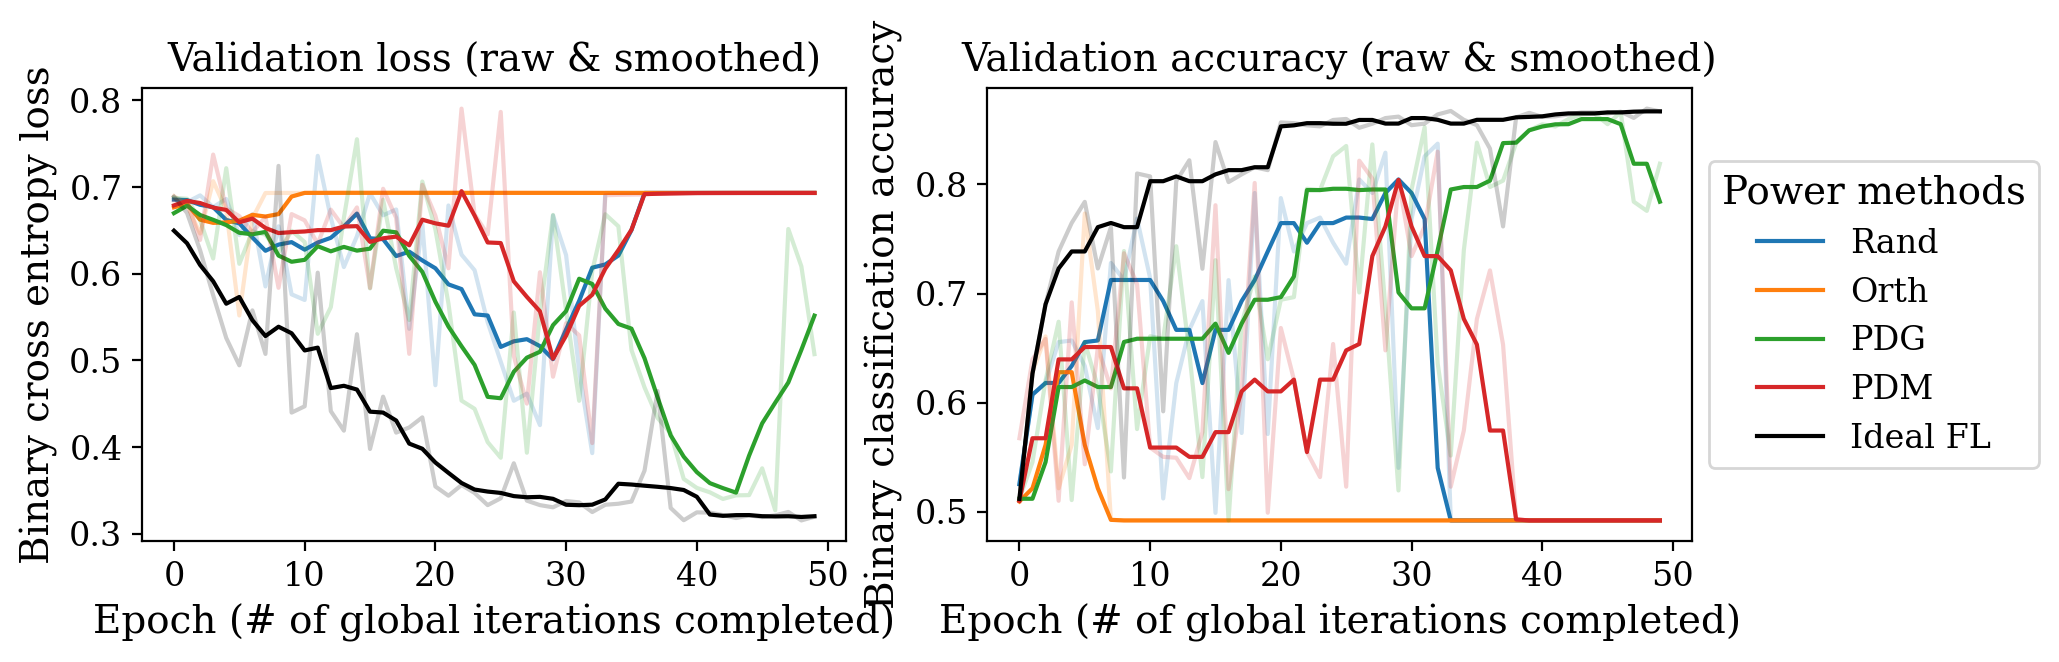

In [187]:
import matplotlib.pyplot as plt
from scipy.signal import medfilt#, uniform_filter1d
from scipy.ndimage import maximum_filter1d, uniform_filter1d

with open(f'./fl_text_results/fl_text_results_{1:02d}.dict.pkl0', 'rb') as handle:
    text_result_dict = pickle.load(handle)
    
    
ccycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(1,2, figsize=(10,3), dpi=200, gridspec_kw={'width_ratios': [1,1]})
fig.patch.set_facecolor('w')

ss = 7 # smooth size
for ki,k in enumerate(list(text_result_dict['val_loss_all'])):#['Rand', 'Orth', 'PDG', 'PDM', 'Ideal FL']):
    c = 'k' if 'ideal' in k.lower() else ccycle[ki]
    val_loss_all = text_result_dict['val_loss_all']
    val_loss = np.array(val_loss_all[k])
    val_loss_smooth = uniform_filter1d(val_loss, ss)  # Apply the Median Filter
    ax[0].plot(val_loss_smooth, color=c)
    ax[0].plot(val_loss, color=c, alpha=.2)
    
#     tra_loss_all = text_result_dict['train_loss_all']
#     tra_loss = np.array(tra_loss_all[k])
#     tra_loss_smooth = uniform_filter1d(tra_loss, ss)  # Apply the Median Filter
#     ax[0].plot(tra_loss_smooth, color=c, ls='--')
#     ax[0].plot(tra_loss, color=c, alpha=.2, ls='--')
    
    val_acc_all = text_result_dict['val_acc_all']
    val_acc = np.array(val_acc_all[k])
    ax[-1].plot(val_acc, color=c, alpha=.2)
    val_acc_smooth = medfilt(val_acc.tolist()+val_acc[-ss:][::-1].tolist(), ss)[:len(val_acc)]  # Apply the Median Filter
    ax[-1].plot(val_acc_smooth, color=c, label=k)

#     tra_acc_all = text_result_dict['train_acc_all']
#     tra_acc = np.array(tra_acc_all[k])
#     ax[-1].plot(tra_acc, color=c, alpha=.2, ls='--')
#     tra_acc_smooth = medfilt(tra_acc.tolist()+tra_acc[-ss:][::-1].tolist(), ss)[:len(tra_acc)]  # Apply the Median Filter
#     ax[-1].plot(tra_acc_smooth, color=c, label=k +' (train)', ls='--')
    
    
# ax[0].set_title('Loss (raw)')
ax[0].set_title('Validation loss (raw & smoothed)')
ax[0].set_ylabel('Binary cross entropy loss')
ax[0].set_xlabel('Epoch (# of global iterations completed)')
ax[-1].set_title('Validation accuracy (raw & smoothed)')
ax[-1].set_ylabel('Binary classification accuracy')
ax[-1].set_xlabel('Epoch (# of global iterations completed)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Power methods')

# plt.plot(val_loss_smooth, '--')
# plt.plot(val_acc_smooth, '--')


In [211]:
with open(f'./fl_text_results/fl_text_results_{0:02d}.dict.pkl', 'rb') as handle:
    text_result_dict = pickle.load(handle)
sum_count = 1

for rr in range(1,10):
    try:
        with open(f'./fl_text_results/fl_text_results_{rr:02d}.dict.pkl', 'rb') as handle:
            text_result_dict_tmp = pickle.load(handle)
    except:
        with open(f'./fl_text_results/fl_text_results_{rr:02d}.dict.pkl0', 'rb') as handle:
            text_result_dict_tmp = pickle.load(handle)     
    sum_count += 1
    for k1 in text_result_dict.keys():
        for k2 in text_result_dict[k1].keys():
            text_result_dict[k1][k2] = np.hstack(
                (text_result_dict[k1][k2], text_result_dict_tmp[k1][k2])
            )
            
text_result_dict_err = {}
for k1 in text_result_dict.keys():
    text_result_dict_err[k1] = {}
    for k2 in text_result_dict[k1].keys():
        vals = np.reshape(
            text_result_dict[k1][k2], [sum_count,-1]
        )
        text_result_dict[k1][k2] = vals#.mean(0)
        text_result_dict_err[k1][k2]= vals.std(0)

FINALERROR = text_result_dict['val_acc_all']

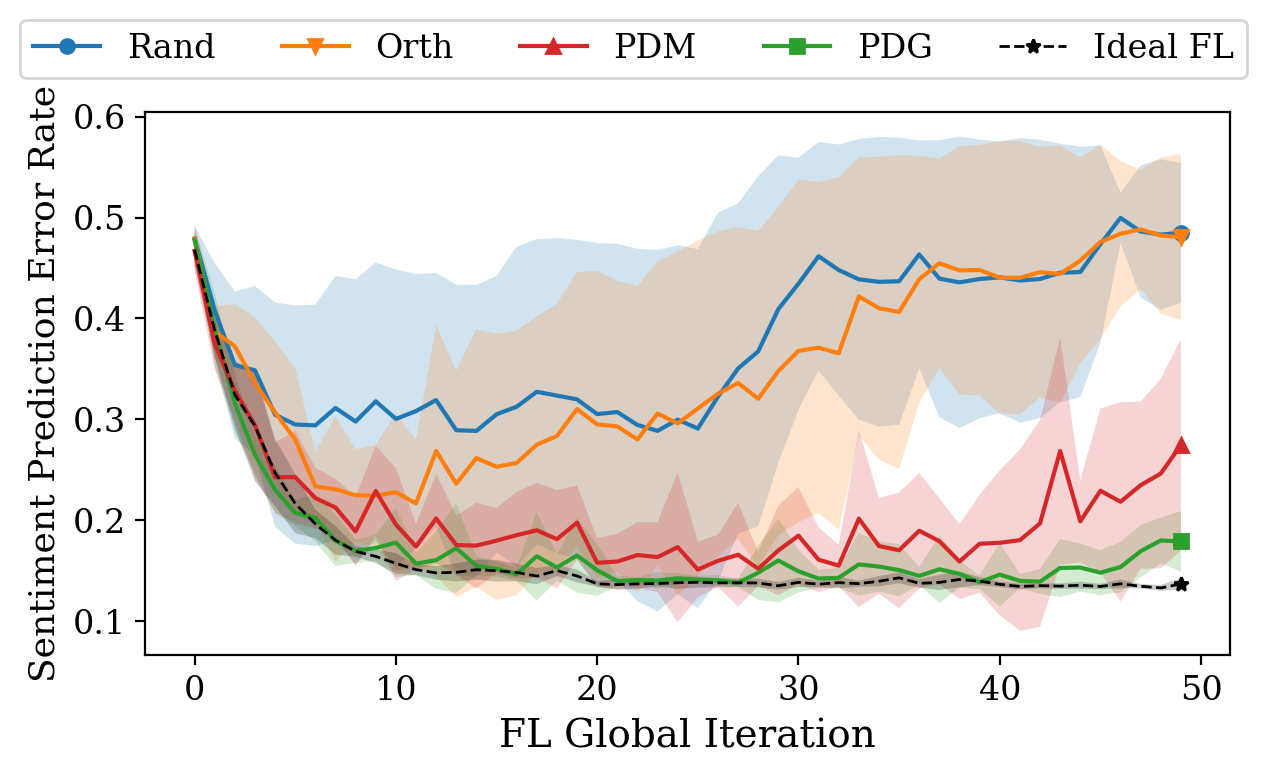

In [213]:
import itertools as it

[FINALERROR[k].sort(0) for k in FINALERROR.keys()]
ylabel_string = 'Sentiment Prediction Error Rate'
max_scale = 1
y_limits = None

pnames = ['Rand','Orth','PDG','PDM','Ideal FL']
ff = 50

fig, ax = plt.subplots(figsize=(7,4),dpi=200)
markercycle = it.cycle(('o','v','s','^','*','+','x')) 
for li, lab in enumerate(pnames):
    vals = 1-FINALERROR[lab][:ff].mean(0)
    color = next(ax._get_lines.prop_cycler)['color']
    marker = next(markercycle)
     
    vv = vals[:ff]/max_scale
    if li < len(pnames)-1:
        ax.plot(vv, markevery=[len(vv)-1], marker=marker, color=color, lw=1.5, label=lab)
    else:
        color = 'black'
        ax.plot(vv, ls='--', color=color, markevery=[len(vv)-1], marker=marker, lw=1, label=lab)
        
    # error shade
    ss = (FINALERROR[lab][:ff]/max_scale).std(0)[:ff]
    plt.fill_between(range(len(vv)), vv-ss, vv+ss, alpha=0.2, edgecolor='none', facecolor=color)


ax.set_ylim(y_limits)
plt.tick_params(axis='y', which='minor')
ax.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))

ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%d"))

ax.set_xlabel('FL Global Iteration')
ax.set_ylabel(ylabel_string, fontsize=13)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend()
handles, labels = ax.get_legend_handles_labels()
labels = pnames
ax.legend([handles[0], handles[1], handles[3], handles[2], handles[4]], 
          [labels[0], labels[1], labels[3], labels[2], labels[4]],
         loc='upper center', bbox_to_anchor=(0.45, 1.2), ncol=5)

# plt.ylim(None, 0.41)
# plt.yscale('log')
plt.show()
